# Sheet 9

## Pretraining LLMs

### (a) BERT

- **Sentence Order Prediction** to predict whether two given sentences are in the correct order.
    - Useful to understand logical reasoning (where the conclusion comes after the premise) and other relationships between sentences.
- **Replaced Token Detection** to predict whether a token has been replaced by a random token and thus doesn't fit in the context.
    - Useful for error detection and understanding the context of a sentence.

### (b) GPT

- **Sentence Completion** to predict multiple tokens at the same time (i.e. without autoregressive generation).
    - Useful to learn how to generate coherent text.
    - Complexity depends on the number of tokens to predict at once.
    - Parallelizable, as the sentence length can be varied, so a single full sentence can be split into multiple independent training samples.

As decoder-only models are made for unidirectional generation, all pretraining tasks kind of end up being fundamentally the same, as they all involve predicting the next token in some way. The difference then only lies in how many tokens are predicted at once and how the training data is prepared. Any further training tasks would require "handcrafted" training data, and would then fall into the realm of fine-tuning.


## Under the hood of LLMs: Llama 2.7B

In [1]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

# Use GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Load token for accessing huggingface model
with open("access_token.txt", "r") as f:
    access_token = f.read().strip()

# Load model and tokenizer
model = "meta-llama/Llama-2-7b-chat-hf"
tokenizer = AutoTokenizer.from_pretrained(model, token=access_token)
model = AutoModelForCausalLM.from_pretrained(model, token=access_token, torch_dtype = torch.float16).to(device)
print(model)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
      )
    )
    (no

In [2]:
# Print some tokens and their corresponding IDs
for id in range(5100, 5110):
    print(f"{id=}, {tokenizer.decode([id])}")

# Print amount of "known" tokens
print("\ntokenizer length:", len(tokenizer))

# Print the token IDs of the string "sun"
sun_id = tokenizer.encode("sun", return_tensors="pt")[-1]
print(f"\n{sun_id=}")

# Convert the tokens back to the string "sun"
print(tokenizer.decode(sun_id))

# Get the embedding vectors of the tokens of the string "sun"
# and print their shapes (2 vectors of size 4096)
emb = model.get_input_embeddings()(sun_id.to(device))
print("embedding shape:", emb.shape)

id=5100, compet
id=5101, pair
id=5102, inglés
id=5103, Response
id=5104, Fig
id=5105, grad
id=5106, documentation
id=5107, cant
id=5108, appreci
id=5109, ån

tokenizer length: 32000

sun_id=tensor([   1, 6575])
<s> sun
embedding shape: torch.Size([2, 4096])


In [3]:
# Create input sequence and extract its tokens
sequence = "My favorite composer is"
model_inputs = tokenizer(sequence, return_tensors="pt").to(device)
print(tokenizer.decode(model_inputs["input_ids"].tolist()[0])) # view tokenized input

# Generate the next token via the model
with torch.no_grad():
    outputs = model(**model_inputs)

# Extract the logits of the last token:
# One value for each token in the vocabulary
logits = outputs['logits'][0, -1, :]
print("\nlogits shape:", logits.shape)

# Apply soft(arg)max to get probabilities for each token
probabilities = torch.nn.functional.softmax(logits, dim=-1)

# Print the 7 most likely tokens and their probabilities
top_k = 7
top_prob, top_ind = torch.topk(probabilities, top_k)

print("\nOutputs:\n")

for i in range(top_k):
    print(f"{tokenizer.decode(top_ind[i].tolist())}: {top_prob[i]:.2f}")

<s> My favorite composer is

logits shape: torch.Size([32000])

Outputs:

Moz: 0.25
Ch: 0.11
Be: 0.09
Ludwig: 0.08
Fr: 0.03
Wolfgang: 0.02
Ig: 0.02


In [4]:
import regex as re

# Start with an empty sequence
sequence = ""
model_inputs = tokenizer(sequence, return_tensors="pt").to(device)

# Generate 30 tokens step by step
generated_answer = ""
for _ in range(30):
    with torch.no_grad():
        outputs = model(**model_inputs)
        logits = outputs['logits'][0, -1, :]
        probabilities = torch.nn.functional.softmax(logits, dim=-1)
        
        # Use the token with the highest probability as the next token
        # and adjust the input sequence accordingly for the next iteration
        next_token_id = torch.argmax(probabilities).unsqueeze(0)
        model_inputs["input_ids"] = torch.cat([model_inputs["input_ids"], next_token_id.unsqueeze(0)], dim=-1)
    
    # Get the token from the ID, remove any invalid characters and
    # append it to the answer string (separated by a space)
    next_word = tokenizer.decode(next_token_id.tolist())
    next_word = re.sub(r"[^a-zA-Z0-9.?!]", "", next_word)
    generated_answer += next_word
    generated_answer += " "
    
    print(generated_answer)

Unterscheidung 
Unterscheidung zwischen 
Unterscheidung zwischen  
Unterscheidung zwischen  K 
Unterscheidung zwischen  K raft 
Unterscheidung zwischen  K raft  
Unterscheidung zwischen  K raft  und 
Unterscheidung zwischen  K raft  und  
Unterscheidung zwischen  K raft  und  K 
Unterscheidung zwischen  K raft  und  K raft 
Unterscheidung zwischen  K raft  und  K raft werk 
Unterscheidung zwischen  K raft  und  K raft werk  
Unterscheidung zwischen  K raft  und  K raft werk   
Unterscheidung zwischen  K raft  und  K raft werk    
Unterscheidung zwischen  K raft  und  K raft werk     
Unterscheidung zwischen  K raft  und  K raft werk     K 
Unterscheidung zwischen  K raft  und  K raft werk     K raft 
Unterscheidung zwischen  K raft  und  K raft werk     K raft  
Unterscheidung zwischen  K raft  und  K raft werk     K raft  und 
Unterscheidung zwischen  K raft  und  K raft werk     K raft  und  
Unterscheidung zwischen  K raft  und  K raft werk     K raft  und  K 
Unterscheidung zwische

## Flow-based modeling

### (a)

As the random variable $X$ follows a uniform distribution, it can be respresented as
$$ X = \mathrm{CDF}_Y(Y). $$

From that, it follows that
$$ Y = \mathrm{CDF}_Y^{-1}(X) \eqqcolon Y'. $$

### (b)

First, we can transform $X$ into a uniform random variable $Z = \mathrm{CDF}_X(X)$. Then we can make use the result from (a) that $Y = \mathrm{CDF}_Y^{-1}(Z)$, where now $Z$ is the uniform random variable. To find the $\mathrm{CDF}_{X/Y}$, we just need to integrate the given PDFs:

$$ \begin{aligned}
    \mathrm{CDF}_X(x) &= \int_{-\infty}^x \frac{1}{2} x' \,\mathrm{d} x' = -\frac{1}{4} x^2 \\
    \mathrm{CDF}_Y(y) &= \int_{-\infty}^y \left(-\frac{1}{2} y' + 1\right) \,\mathrm{d} y' = -\frac{1}{4} y^2 + y \\
\end{aligned} $$

The inverse CDF then follows as
$$ \mathrm{CDF}_Y^{-1}(y) = 2 - 2 \sqrt{1 - y}. $$

In [23]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['font.size'] = 9
plt.rcParams['figure.figsize'] = (12 / 2.54, 6 / 2.54)
plt.rcParams['figure.constrained_layout.use'] = True

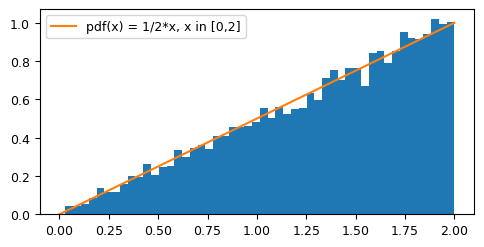

In [24]:
# load the 1d samples:
samples = np.load("data/samples_1d.npy")

x_lin = np.linspace(0, 2, 1000)
plt.hist(samples, bins=50, density=True)
plt.plot(x_lin, 1/2 * x_lin, label="pdf(x) = 1/2*x, x in [0,2]")
plt.legend()
plt.show()

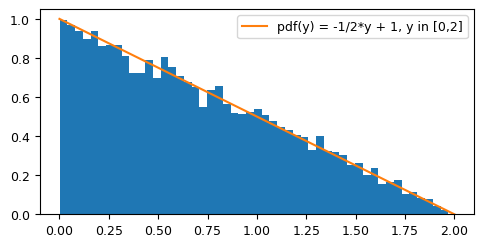

In [25]:
# Transform the samples to samples from pdf(y) = -1/2*y + 1, y in [0,2]

def cdf_x(x):
    return 1/4 * x**2

def cdf_y_inv(y):
    return 2 - 2 * np.sqrt(1 - y)

transformed = cdf_y_inv(cdf_x(samples))

plt.hist(transformed, bins=50, density=True)
plt.plot(x_lin, -1/2*x_lin + 1, label="pdf(y) = -1/2*y + 1, y in [0,2]")
plt.legend()
plt.show()

### (c)

The _marginal radial distribution_ is given by
$$ p_R(r) = r\, e^{-\frac{1}{2} r^2}. $$

To sample from a 2D standard normal, we use
$$ X_1 = R \cos(\Phi), \qquad X_2 = R \sin(\Phi) $$

The random variable $\Phi$ can trivially be generated from an on $[0, 1]$ uniformly distributed random variable $U_1$ as $\Phi = 2\pi U_1$. For the radial part, we can use the inverse CDF method from (a):

$$ \begin{aligned}
    \mathrm{CDF}_R(r) &= \int_0^r \mathrm{d} x \, e^{-\frac{1}{2} x^2} \, = 1 - e^{-\frac{1}{2} r^2} \\
    \mathrm{CDF}_R^{-1}(u) &= \sqrt{-2 \ln(1 - u)}.
\end{aligned} $$

We can then sample $R$ from a uniform random variable $U_2$. As the the distribution of $1 - U_2$ is the same as of $U_2$, it follows that

$$ R = \sqrt{-2 \ln(1 - U_2)} = \sqrt{-2 \ln(U_2)}. $$

For the total sampling, we can then just multiply the two random variables, which results in the equations for the basic Box-Muller transform:

$$ \begin{aligned}
    X_1 &= \sqrt{-2 \ln(U_2)} \cos(2\pi U_1) \\
    X_2 &= \sqrt{-2 \ln(U_2)} \sin(2\pi U_1).
\end{aligned} $$

### (d)

### (e)